In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [41]:
xi_file = '/mnt/store1/oliverphilcox/3PCF_QPM/test_run.v01/qpm.sum'
n_bins = 18
n_mult = 6

import re,string

start=False
zeta = np.zeros([n_bins,n_bins,n_mult+1])
powerD = np.zeros([n_bins,n_bins,n_mult+1])
powerD_sigma = np.zeros([n_bins,n_bins,n_mult+1])
            
with open(xi_file,"r") as xi_in:
    for line in xi_in:
        if not start:
            if(re.match("Three-point ",line)):
                start=True
                continue
        if(re.match("Two-point Correlation",line)):
            start=False
            continue
        if start:
            strip_line = line.strip()
            if len(strip_line)==0:
                continue
            split_line=strip_line.split()
            r1 = int(split_line[0])
            r2 = int(split_line[1])
            for i in range(n_mult+1):
                if i==0:
                    ind=2
                else:
                    ind=i+2
                print('l',split_line[ind].strip('[]'))
                if split_line[-1]=='zeta':
                    zeta[r1,r2,i]=float(split_line[ind].strip('[]'))
                if split_line[-1]=='raw':
                    powerD[r1,r2,i]=float(split_line[ind].strip('[]'))
                if split_line[-1]=='sigma':
                    powerD_sigma[r1,r2,i]=float(split_line[ind].strip('[]'))
            
            

In [91]:
x='[4'

In [95]:
float(x.strip('['))

4.0

In [94]:
x

'[4'

In [84]:
split_line

['1',
 '0',
 '-0.0135080',
 '[-6.35913',
 '-19.94822',
 '-9.70408',
 '-8.52908',
 '-5.22305',
 '-5.16791]',
 'zeta']

## Load data


In [424]:
dat = np.load('/mnt/store1/oliverphilcox/3PCF_QPM/test_run.v02/3pcf_output.npz')

In [425]:
r_bins = np.linspace(5,175,dat.f.bins)
ells = np.arange(dat.f.order+1)

In [510]:
zeta=dat.f.zeta ## 3pcf estimate
powerD = dat.f.powerD ## N_l/R_0
powerDsig = dat.f.powerDsig ## N_l/R_0 stdev
for b1 in range(len(zeta)):
    for b2 in range(b1):
        zeta[b1,b2,1:]*=zeta[b1,b2,0]
        #zeta[b1,b2,:]=zeta[b2,b1,:]
        powerD[b1,b2,1:]*=powerD[b1,b2,0]
        #powerD[b1,b2,:]=powerD[b2,b1,:]
        powerDsig[b1,b2,:]*=powerD[b1,b2,0]
        #powerDsig[b1,b2,:]=powerDsig[b2,b1,:]
        
xi = dat.f.xi # 2pcf
xisig = dat.f.xisig # 2pcf stdev

<ErrorbarContainer object of 3 artists>

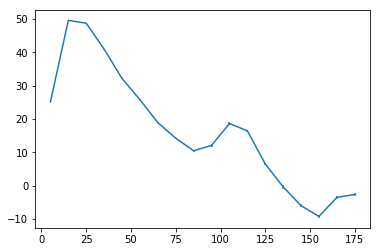

In [499]:
plt.errorbar(r_bins,r_bins**2*dat.f.xi,r_bins**2*dat.f.xisig)

### Try SE16c compression

In [500]:
delta_r = r_bins[1]-r_bins[0]
r_min = r_bins-delta_r/2

zeta_compress = np.zeros([len(r_bins),dat.f.order+1])
powerD_compress = np.zeros([len(r_bins),dat.f.order+1])
powerDsig_compress = np.zeros([len(r_bins),dat.f.order+1])
denom = np.zeros([len(r_bins)])

for b1,r1 in enumerate(r_min):
    ct=0
    for b2,r2 in enumerate(r_min):
        if r2>=3*delta_r and r2<r1-3*delta_r:
            vol_2 = 4.*np.pi/3.*((r2+delta_r)**3-r2**3)
            zeta_compress[b1,:]+=zeta[b1,b2,:]*vol_2
            powerD_compress[b1,:]+=powerD[b1,b2,:]*vol_2
            powerDsig_compress[b1,:]+=powerDsig[b1,b2,:]*vol_2
            denom[b1]+=vol_2
            ct+=1
    if ct>0:
        zeta_compress[b1]/=denom[b1]
        powerD_compress[b1]/=denom[b1]
        powerDsig_compress[b1]/=denom[b1]

/home/oliverphilcox/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


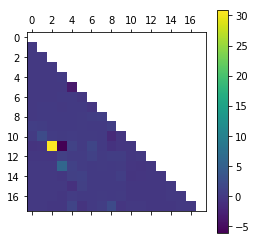

In [508]:
plt.matshow(powerDsig[:,:,0]/powerD[:,:,0])
plt.colorbar()

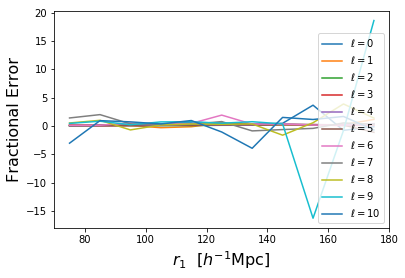

In [506]:
for ell in range(dat.f.order+1):
    #plt.figure()
    plt.errorbar(r_bins[7:],powerDsig_compress[7:,ell]/powerD_compress[7:,ell],label=r'$\ell = %d$'%ell)
plt.legend();
plt.xlabel(r'$r_1$  $[h^{-1}\mathrm{Mpc}]$',fontsize=16)
plt.ylabel(r'Fractional Error',fontsize=16);

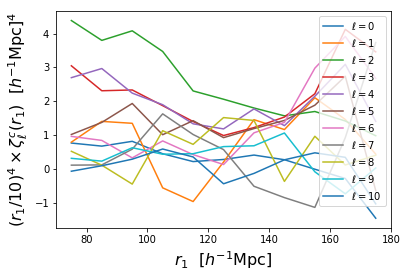

In [494]:
for ell in range(dat.f.order+1):
    #plt.figure()
    plt.errorbar(r_bins[7:],(r_bins[7:]/10)**4*zeta_compress[7:,ell],label=r'$\ell = %d$'%ell)
plt.legend();
plt.xlabel(r'$r_1$  $[h^{-1}\mathrm{Mpc}]$',fontsize=16)
plt.ylabel(r'$(r_1/10)^4\times\zeta^c_\ell(r_1)$  $[h^{-1}\mathrm{Mpc}]^4$',fontsize=16);

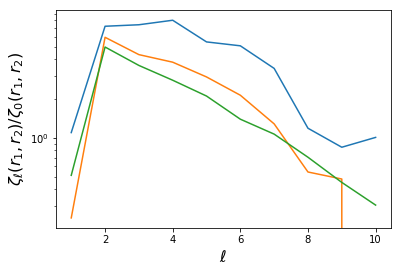

In [495]:
plt.plot(ells[1:],zeta[7,4,1:]/zeta[7,4,0])
plt.plot(ells[1:],zeta[6,3,1:]/zeta[6,3,0])
plt.plot(ells[1:],zeta[4,2,1:]/zeta[4,2,0])
plt.ylabel(r'$\zeta_\ell(r_1,r_2)/\zeta_0(r_1,r_2)$',fontsize=16)
plt.xlabel(r'$\ell$',fontsize=16)
plt.yscale('log')

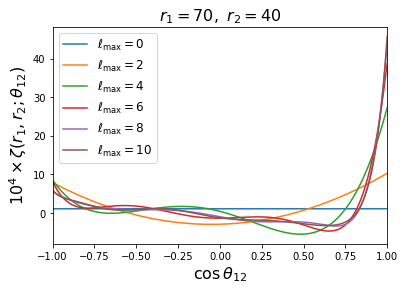

In [496]:
from scipy.special import legendre

for ell_max in [0,2,4,6,8,10]:
    these_ell = np.arange(0,ell_max+1)
    mus = np.arange(-1,1,0.001)
    ddat=[]
    for ell in these_ell:
        ddat.append(legendre(ell)(mus)*zeta[7,4][ell])
    dddat = np.sum(np.asarray(ddat),axis=0)
    plt.plot(mus,1e4*dddat,label=r'$\ell_\mathrm{max} = %d$'%ell_max)
plt.legend(fontsize=12);
plt.xlim([-1,1])
plt.xlabel(r'$\cos\,{\theta_{12}}$',fontsize=16)
plt.ylabel(r'$10^4\times \zeta(r_1,r_2;\theta_{12})$',fontsize=16)
plt.title(r'$r_1 = 70,\,\,r_2 = 40$',fontsize=16);